In [1]:
# import basic libraries
import pandas as pd
import numpy as np

# import plotting libraries
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import string

# NLP libraries
import nltk
!pip install nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

# Import Scikit Learn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score 
from sklearn.metrics import plot_roc_curve, f1_score, hamming_loss, cohen_kappa_score, matthews_corrcoef, log_loss
from sklearn.naive_bayes import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kqtan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kqtan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kqtan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
sms = pd.read_csv("SMSSpamCollection", sep = "\t", header = None)
sms = sms.rename({0:"Class", 1: "Text"}, axis=1)

In [3]:
# Remove the duplicates
sms = sms.drop_duplicates(keep="first")

# Verify the number duplicates
display(sms.duplicated().sum())

0

In [4]:
# include binary label for classes ham and spam
sms["Label"] = sms["Class"].map({"ham": 0, "spam": 1})

# introduce few parameters to accommodate the analysis
# number of characters
sms["Num_char"] = sms["Text"].apply(len)

# number of words
sms["Num_words"] = sms["Text"].apply(lambda x: len(nltk.word_tokenize(x)))

# number of sentences
sms["Num_sentences"] = sms["Text"].apply(lambda x: len(nltk.sent_tokenize(x)))

display(sms.sample(10))

,Class,Text,Label,Num_char,Num_words,Num_sentences
2389,ham,wiskey Brandy Rum Gin Beer Vodka Scotch Shampa...,0,89,17,2
1704,ham,Just taste fish curry :-P,0,25,6,1
1194,spam,Sex up ur mobile with a FREE sexy pic of Jorda...,1,154,34,5
1675,ham,Nah dub but je still buff,0,25,6,1
3575,ham,Yeah sure I'll leave in a min,0,29,8,1
2710,ham,Sorry de i went to shop.,0,24,7,1
195,ham,How are you doing? Hope you've settled in for ...,0,92,22,3
3166,ham,Cheers for the card ... Is it that time of yea...,0,56,13,1
2750,ham,You said not now. No problem. When you can. Le...,0,56,16,4
2046,ham,Okay... I booked all already... Including the ...,0,59,13,3


In [5]:
# necessary tools for NLP
punctuation = string.punctuation
stop_words = set(stopwords.words("english"))

# lemmatization operator
lemmatizer = WordNetLemmatizer()

# function to process the text
def text_cleaner(text):
    x = []
    remove_punct = "".join([char for char in text if char not in punctuation])
    lowercase = word_tokenize(remove_punct.lower())
    
    for w in lowercase:
        if w not in stop_words:
            x.append(lemmatizer.lemmatize(w))
    return " ".join(x)


sms["Processed"]=sms["Text"].apply(text_cleaner)
display(sms.sample(5))

,Class,Text,Label,Num_char,Num_words,Num_sentences,Processed
3481,ham,What was she looking for?,0,25,6,1,looking
5541,ham,Yeah it's jus rite...,0,21,6,1,yeah jus rite
2284,ham,I reach home safe n sound liao...,0,33,8,1,reach home safe n sound liao
422,spam,Someone has contacted our dating service and e...,1,162,28,3,someone contacted dating service entered phone...
821,ham,Good afternoon starshine! How's my boytoy? Doe...,0,131,32,5,good afternoon starshine hows boytoy crave yet...


In [6]:
def check_train_test():
    print("Shape of Training input set:", X_train.shape)
    print("Shape of Traning output set:", y_train.shape)
    print("\n")
    print("Shape of Testing input set:", X_test.shape)
    print("Shape of Testing output set:", y_test.shape)

In [7]:
# k-fold cross validation, using k = 10
# k-fold cross validation, using k = 10
def skfold(model, name):
    tfidf_vec = TfidfVectorizer()
    X = tfidf_vec.fit_transform(sms["Text"].apply(text_cleaner)).toarray()
    y = np.array(sms["Label"])
    np.random.seed(2022)
    test_score = []
    train_score = []
    prec = []
    recall = []
    lg_loss = []
    ham_loss =[]
    kappa = []
    matthews = []
    skf = StratifiedKFold(n_splits = 10, shuffle = True)
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train_pred = model.predict(X_train)
        pred_proba = model.predict_proba(X_test)
        
        test_score.append(accuracy_score(y_test, y_pred))
        train_score.append(accuracy_score(y_train, train_pred))
        prec.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        lg_loss.append(log_loss(y_test, pred_proba))
        ham_loss.append(hamming_loss(y_test, y_pred))
        kappa.append(cohen_kappa_score(y_test, y_pred))
        matthews.append(matthews_corrcoef(y_test, y_pred))
        
    print(f"Training Set Accuracy : {round(sum(train_score) / len(train_score) * 100, 5)} %\n")
    print(f"Test Set Accuracy : {round(sum(test_score) / len(test_score) * 100, 5)} % \n")
    print(f"Precision : {round(sum(prec) / len(prec) * 100, 5)} % \n")
    print(f"Recall : {round(sum(recall) / len(recall) * 100, 5)} % \n")
    print(f"Hamming Loss : {round(sum(ham_loss) / len(ham_loss) * 100, 5)} % \n")
    print(f"Cross Entropy Loss : {round(sum(lg_loss) / len(lg_loss), 5)} \n")
    print(f"Kappa Statistics : {round(sum(kappa) / len(kappa), 5)} \n")
    print(f"Matthews Correlation : {round(sum(matthews) / len(matthews), 5)} \n\n")
    
    # in progress
    """
    final_prec = sum(prec) / len(prec)
    final_recall = sum(recall) / len(recall)
    ax = plt.subplot()
    ax.scatter(final_recall, final_prec)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve of "+ name + " on Test set")
    
    plt.show()
    """

In [8]:
def plot_performance(model, name):
    ax = plt.subplot()
    y_pred = model.predict(X_test)
    
    print(f"Training Set Accuracy : {round(accuracy_score(y_train, train_pred) * 100, 5)} %\n")
    print(f"Test Set Accuracy : {round(accuracy_score(y_test, y_pred) * 100, 5)} % \n")
    print(f"Hamming Loss : {round(hamming_loss(y_test, y_pred) * 100, 5)} % \n")
    print(f"Cross Entropy Loss : {round(log_loss(y_test, pred_proba), 5)} \n")
    print(f"Kappa Statistics : {round(cohen_kappa_score(y_test, y_pred), 5)} \n")
    print(f"Matthews Correlation : {round(matthews_corrcoef(y_test, y_pred), 5)} \n\n")
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="g", cmap = "Blues")
    # given the confusion matrix in sklearn follows order (ie. 0, 1, 2, ...)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("Actual labels")
    ax.set_title("Confusion Matrix of "+ name + " on Test set")
    ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    plt.show()
    
    clr = classification_report(y_test, y_pred)
    print(name + ": Classification Report on Test Set:\n-------------------------------------------------------\n", clr)
    
    plot_roc_curve(model, X_test, y_test)
    
    plt.show()

# Modelling

## Complement Naive Bayes

In [9]:
cnb = ComplementNB()

In [11]:
tfidf_vec = TfidfVectorizer()
X = tfidf_vec.fit_transform(sms["Text"].apply(text_cleaner)).toarray()
y = sms["Label"]

# linear sampling
np.random.seed(2022)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40)
check_train_test()

Shape of Training input set: (3101, 8901)
Shape of Traning output set: (3101,)


Shape of Testing input set: (2068, 8901)
Shape of Testing output set: (2068,)


Training Set Accuracy : 98.35537 %

Test Set Accuracy : 93.27853 % 

Hamming Loss : 6.72147 % 

Cross Entropy Loss : 0.2221 

Kappa Statistics : 0.73918 

Matthews Correlation : 0.75227 




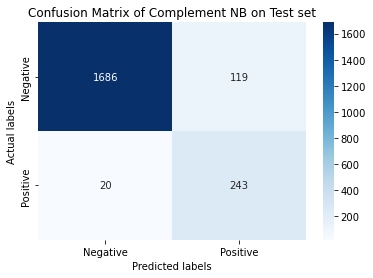

Complement NB: Classification Report on Test Set:
-------------------------------------------------------
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      1805
           1       0.67      0.92      0.78       263

    accuracy                           0.93      2068
   macro avg       0.83      0.93      0.87      2068
weighted avg       0.95      0.93      0.94      2068



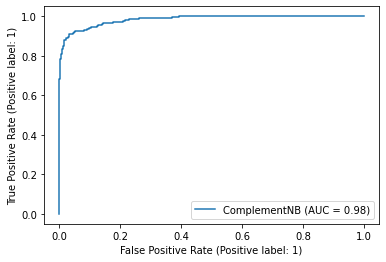

In [12]:
# train and test the model
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
train_pred = cnb.predict(X_train)
pred_proba = cnb.predict_proba(X_test)

# show the performance
plot_performance(cnb, "Complement NB")

In [13]:
# stratified sampling
np.random.seed(2022)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)
check_train_test()

Shape of Training input set: (3101, 8901)
Shape of Traning output set: (3101,)


Shape of Testing input set: (2068, 8901)
Shape of Testing output set: (2068,)


Training Set Accuracy : 98.61335 %

Test Set Accuracy : 93.56867 % 

Hamming Loss : 6.43133 % 

Cross Entropy Loss : 0.21879 

Kappa Statistics : 0.74033 

Matthews Correlation : 0.7484 




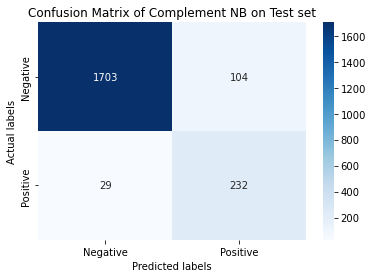

Complement NB: Classification Report on Test Set:
-------------------------------------------------------
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      1807
           1       0.69      0.89      0.78       261

    accuracy                           0.94      2068
   macro avg       0.84      0.92      0.87      2068
weighted avg       0.95      0.94      0.94      2068



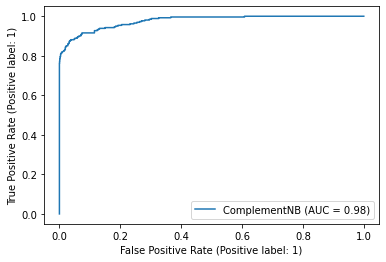

In [14]:
# train and test the model
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
train_pred = cnb.predict(X_train)
pred_proba = cnb.predict_proba(X_test)

# show the performance
plot_performance(cnb, "Complement NB")

In [10]:
skfold(cnb, "Complement NB")

Training Set Accuracy : 97.56669 %

Test Set Accuracy : 93.05497 % 

Precision : 65.94882 % 

Recall : 93.42424 % 

Hamming Loss : 6.94503 % 

Cross Entropy Loss : 0.21197 

Kappa Statistics : 0.73335 

Matthews Correlation : 0.74906 




In [15]:
# not needed for now
cv = CountVectorizer(analyzer = text_cleaner)
cv.fit(sms["Text"])
cvt = cv.transform(sms["Text"])
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(cvt)
messages_tfidf = tfidf_transformer.transform(cvt)
c_data = pd.DataFrame(messages_tfidf.toarray())
c_data.head()
# maybe a short analysis on the matrix
# in lecture notes, it is the feature table
# just to from a decent table to have a look on the data

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,0.569504,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.526595,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.453736,0.317691,0.316382,0.291419,0.0,0.064586,0.20211,0.0,0.145003,0.260881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.575733,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.496530,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
tfidf = TfidfVectorizer()
tfidf_vec = tfidf.fit_transform(sms["Processed"])
t_data = pd.DataFrame(tfidf_vec.toarray())
t_data.head()

,0,1,2,3,4,5,6,7,8,9,...,8891,8892,8893,8894,8895,8896,8897,8898,8899,8900
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# this one took forever, any way to do it faster?
import statistics as stats
print(X.apply(stats.variance).describe())

In [ ]:
# from the statistical info of X, the variance seems to be small
# but given the significant difference between max and min
# we will scale the data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
np.random.seed(2022)
#sc = StandardScaler()
#X = sc.fit_transform(X)
#X = normalize(X)

# reduce the dimensionality to 3 features
pca = PCA(n_components = 3)
df_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(df_pca, columns = ["PC1", "PC2", "PC3"])  
print(df_pca)

In [ ]:
# Create cluster using Agglomerative hierarchical clustering
# by default, the linkage is ward and metric euclidean
agc = AgglomerativeClustering(n_clusters = 3)
agc.fit(df_pca)
plt.figure(figsize = (8, 14))
# PC1 vs PC2
plt.subplot(3, 1, 1)
plt.scatter(df_pca["PC1"], df_pca["PC2"], c = agc.labels_, cmap = "rainbow")
plt.title("Agglomerative Hierarchical Clusters with n = 3")
plt.xlabel("PC1")
plt.ylabel("PC2")

# PC1 vs PC3
plt.subplot(3, 1, 2)
plt.scatter(df_pca["PC1"], df_pca["PC3"], c = agc.labels_, cmap = "rainbow")
plt.title("Agglomerative Hierarchical Clusters with n = 3")
plt.xlabel("PC1")
plt.ylabel("PC3")

# PC2 vs PC3
plt.subplot(3, 1, 3)
plt.scatter(df_pca["PC2"], df_pca["PC3"], c = agc.labels_, cmap = "rainbow")
plt.title("Agglomerative Hierarchical Clusters with n = 3")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.show()       

In [ ]:
# Try to visualise with num of clusters = 4
agc = AgglomerativeClustering(n_clusters = 4)
agc.fit(df_pca)
plt.figure()
plt.scatter(df_pca["PC1"], df_pca["PC2"], c = agc.labels_, cmap = "rainbow")

plt.title("Agglomerative Hierarchical Clusters with n = 4")

plt.show()     

In [ ]:
agc = AgglomerativeClustering(n_clusters = 5)
agc.fit(df_pca)
plt.figure()
plt.scatter(df_pca["PC1"], df_pca["PC2"], c = agc.labels_, cmap = "rainbow")

plt.title("Agglomerative Hierarchical Clusters with n = 5")

plt.show()    